In [ ]:
#  structure modeling for aggregate data 

In [20]:
import pandas as pd
import numpy as np
import scipy.stats as spstats
from cairosvg import svg2png
from cairosvg import svg2pdf 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## 1. Figure 4d --- ---

In [3]:
def parse_struct(struct):
    list_of_pairs = []
    list_queue = []
    for i2, ss in enumerate(struct):
        if ss == "(":
            list_queue.append(i2)
        elif ss == ")":
            i1 = list_queue.pop()
            list_of_pairs.append((i1, i2))
    return list_of_pairs


def parse_svg(f_svg):

    ### part 1 

    nuc_positions, nuc_type = [], []
    pos_position, pos_count = [], []
    with open(f_svg, "r") as f:
        for line in f:
            if "</text>" in line:
                if "rgb(0%, 0%, 0%)" in line:
                    row = line.split(">")[1].split("<")[0].replace("T","U")
                    if len(row) == 1:
                        nuc_type.append(row)
                        x = float(line.split('x="')[1].split('"')[0])
                        y = float(line.split('y="')[1].split('"')[0])
                        nuc_positions.append([x, y])
                else:
                    posmark = int(line.split(">")[1].split("<")[0])
                    x = float(line.split('x="')[1].split('"')[0])
                    y = float(line.split('y="')[1].split('"')[0])
                    pos_position.append([x, y])
                    pos_count.append(posmark) # no need offset since the svh alrd has offset coordinates
    

    ### part 2
                    
    pos_position_line_start, pos_position_line_end= [], []
    
    with open(f_svg, "r") as f:
        
        for line in f:

            if "</text>" not in line:
                
                if 'stroke-width="1.0"' and "rgb(25%, 25%, 25%)" in line:

                    row = line.split(" ")
                    #print(row)

                
                    x1 = float(row[1].split('x1="')[1].split('"')[0])
                    y1 = float(row[2].split('y1="')[1].split('"')[0])
                    x2 = float(row[3].split('x2="')[1].split('"')[0])
                    y2 = float(row[4].split('y2="')[1].split('"')[0])

                    pos_position_line_start.append([x1, y1])
                    pos_position_line_end.append([x2, y2])
            
                   
    return nuc_positions, nuc_type, pos_position, pos_count, pos_position_line_start, pos_position_line_end


def append_header(list_svg_output, span_x, span_y, margin):
    
    list_svg_output.append('''<?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" 
    "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
    ''')

    list_svg_output.append('<svg width="%f" height="%f" version="1.1" xmlns="http://www.w3.org/2000/svg">'%(span_x + 2*margin, span_y + 2*margin))

def append_bp_line(list_svg_output, pairs, nuc_positions, margin, nuc_type, pair_circle_radius):

    # draw base pairing line
    for p in pairs:
        pos1, pos2 = p[0], p[1]  # alrd corrected to zero based
        x1 = nuc_positions[p[0]][0] + margin
        y1 = nuc_positions[p[0]][1] + margin
        x2 = nuc_positions[p[1]][0] + margin
        y2 = nuc_positions[p[1]][1] + margin
        if not ((nuc_type[pos1]=="G" or nuc_type[pos1]=="C") and (nuc_type[pos2]=="G" or nuc_type[pos2]=="C")): # draw a circle to note GC pairing
            list_svg_output.append('<line x1="%f" y1="%f" x2="%f" y2="%f" stroke="rgb(0%%, 0%%, 0%%)" stroke-width="1.0" />'%(x1,y1,x2,y2))
            list_svg_output.append('<circle cx="%f" cy="%f" r="%f" stroke="rgb(0%%, 0%%, 0%%)" stroke-width="1.0" fill="rgb(0%%, 0%%, 0%%)" />'%((x1+x2)/2, (y1+y2)/2, pair_circle_radius))
        else:
            list_svg_output.append('<line x1="%f" y1="%f" x2="%f" y2="%f" stroke="rgb(0%%, 0%%, 0%%)" stroke-width="1.0" />'%(x1,y1,x2,y2))


def append_nt_line(list_svg_output, nuc_positions, margin):

    # draw adjacent nt line
    for n in range(len(nuc_positions)-1): 
        x1 = nuc_positions[n][0] + margin
        y1 = nuc_positions[n][1] + margin
        x2 = nuc_positions[n+1][0] + margin
        y2 = nuc_positions[n+1][1] + margin
        list_svg_output.append('<line x1="%f" y1="%f" x2="%f" y2="%f" stroke="rgb(0%%, 0%%, 0%%)" stroke-width="1.0" />'%(x1,y1,x2,y2))

def append_circles(list_svg_output, nuc_positions, nuc_type, nuc_color, margin, nt_circle_radius):
    # draw circles
    for n, nuc in enumerate(nuc_type):
        x = nuc_positions[n][0]+ margin
        y = nuc_positions[n][1]+ margin
        list_svg_output.append('<circle cx="%f" cy="%f" r="%f" stroke="None" fill="%s"/>'%(x, y, nt_circle_radius, nuc_color[n]))
        list_svg_output.append('<text x="%f" y="%f" text-anchor="middle" font-family="Verdana" font-size="10.5" >%s</text>'%(x,y+3.5,nuc))


def append_positions(list_svg_output, pos_count, pos_position, margin, offset):
    # draw position labels
    for p, pos in enumerate(pos_count):
        x = pos_position[p][0] + margin/1.5
        y = pos_position[p][1] + margin/1.5
        #x = pos_position[p][0] + margin/2
        #y = pos_position[p][1] + margin/2
        list_svg_output.append('<text x="%f" y="%f" text-anchor="start" font-family="Verdana" font-size="10" >%s</text>'%(x, y, pos+offset)) # change anchor to "end"

def append_footer(list_svg_output):
    list_svg_output.append('</svg>')


def shape_to_color_v5(shape):
    if shape < -998:
        return "rgb(100%, 100%, 100%)"
    else:
        if shape >0.85:
            return 'rgb(90%,0%,20%)'
        elif shape > 0.4:
            return 'rgb(255,127,0)'
        else:
            return 'rgb(128,128,128)'      


def annotate_svg(f_svg, pairs, shape, f_out_svg, offset, p_colormap=True):

    nuc_positions, nuc_type, pos_position, pos_count, pos_position_line_start, pos_position_line_end = parse_svg(f_svg)

    if not p_colormap:
        nuc_color = [shape_to_color_v5(s) for s in shape]
    else:
        cmap = matplotlib.cm.get_cmap('Reds')
        shape_nona = [x for x in shape if x!=-999]
        if shape_nona==[]:
            nuc_color=[(100,100,100)]*len(shape)
        else:
            print(shape_nona)
            norm = matplotlib.colors.Normalize(vmin=min(shape_nona), vmax=max(shape_nona)) # vmax is black, offset a bit
            nuc_color = list(map(lambda x: cmap(norm(x)) if x!=-999 else (100,100,100), shape)) # scale only non NA shape, if NA make it white
        nuc_color = list(map(lambda tup: f"rgb({tup[0]*100}%, {tup[1]*100}%, {tup[2]*100}%)", nuc_color)) # render to string


    # get maximum and minimum of x and y to define svg size
    nuc_positions = np.array(nuc_positions)
    min_x = min(nuc_positions[:,0])
    max_x = max(nuc_positions[:,0])
    min_y = min(nuc_positions[:,1])
    max_y = max(nuc_positions[:,1])

    span_x = abs(max_x-min_x)
    span_y = abs(max_y-min_y)

    for n in range(len(nuc_positions)):
        nuc_positions[n] = nuc_positions[n]-np.array(min_x,min_y)
        

    # draw setting
    nt_circle_radius = 6
    #nt_circle_radius = 3
    pair_circle_radius = 2.75 #same as varna, for the AT pairing
    margin = 50 # the edges of the svg always get cutoff. add margin to avoid this. 
    
    #offset = 824
    list_svg_output = []
    append_header(list_svg_output, span_x, span_y, margin)
    append_bp_line(list_svg_output, pairs, nuc_positions, margin, nuc_type, pair_circle_radius)
    append_nt_line(list_svg_output, nuc_positions, margin)
    append_circles(list_svg_output, nuc_positions, nuc_type, nuc_color, margin, nt_circle_radius)
    append_positions(list_svg_output, pos_count, pos_position, margin, offset)
    append_footer(list_svg_output)

    with open(f_out_svg, "w") as f:
        for line in list_svg_output:
            f.write("%s\n" % line)

In [6]:
def get_structure_model(transcript1,transcript2,transcript3,order,C0_30C,C0_37C,C1_30C,C1_37C,offset): 

    pairs_C0_30C= parse_struct(C0_30C)
    pairs_C0_37C= parse_struct(C0_37C)
    pairs_C1_30C= parse_struct(C1_30C)
    pairs_C1_37C= parse_struct(C1_37C)

    dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/' 
    pred = pd.read_csv(dir+'/X_pred_'+transcript1+'_1000_0.5.txt', sep='\t') 

    try: 
            
        ## 1. C0_30C
        flt = pred[(pred['group'] == 'X_pred_WT_inWT')]
        X_pred_WT_inWT = flt.drop(columns=['iid','group'])

        mod = X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0]
        mod = pd.DataFrame(mod)
        mod.columns = ['mod_rate']
        mod['position'] = mod.index 
        mod['position'] = mod['position'].astype(int)
        mod = mod.reset_index()
        mod['position'] = mod.index 
        mod = mod[['position','mod_rate']]
        mod = mod[['mod_rate']]

        norm_factor = max(spstats.iqr(mod['mod_rate'].dropna()) * 1.5, np.percentile(mod['mod_rate'].dropna(), 90))
        print(norm_factor)
        modrate_pred = list(mod.mod_rate/norm_factor)


        annotate_svg(dir+transcript2+"_cluster0_Nolig.stochastic.centroid."+str(order)+".svg", 
                pairs_C0_30C, modrate_pred, 
                dir+transcript3+"_cluster0_30C.color."+str(order)+".svg", 0, p_colormap=False) 
        svg2pdf(url=dir+transcript3+"_cluster0_30C.color."+str(order)+".svg", write_to=dir+transcript3+"_cluster0_30C.color."+str(order)+".pdf", dpi=300)

    except Exception:
                pass 


    try: 
        ## 1. C0_37C
        flt = pred[(pred['group'] == 'X_pred_WT_inMT')]
        X_pred_WT_inWT = flt.drop(columns=['iid','group'])

        mod = X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0]
        mod = pd.DataFrame(mod)
        mod.columns = ['mod_rate']
        mod['position'] = mod.index 
        mod['position'] = mod['position'].astype(int)
        mod = mod.reset_index()
        mod['position'] = mod.index 
        mod = mod[['position','mod_rate']]
        mod = mod[['mod_rate']]

        norm_factor = max(spstats.iqr(mod['mod_rate'].dropna()) * 1.5, np.percentile(mod['mod_rate'].dropna(), 90))
        print(norm_factor)
        modrate_pred = list(mod.mod_rate/norm_factor)

        annotate_svg(dir+transcript2+"_cluster0_Lig.stochastic.centroid."+str(order)+".svg", 
                pairs_C0_37C, modrate_pred, 
                dir+transcript3+"_cluster0_37C.color."+str(order)+".svg",0, p_colormap=False)
        svg2pdf(url=dir+transcript3+"_cluster0_37C.color."+str(order)+".svg", write_to=dir+transcript3+"_cluster0_37C.color."+str(order)+".pdf", dpi=300)

    except Exception:
                pass 


    try:
        ## 3. C1_30C
        flt = pred[(pred['group'] == 'X_pred_MT_inWT')]
        X_pred_WT_inWT = flt.drop(columns=['iid','group'])

        mod = X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0]
        mod = pd.DataFrame(mod)
        mod.columns = ['mod_rate']
        mod['position'] = mod.index 
        mod['position'] = mod['position'].astype(int)
        mod = mod.reset_index()
        mod['position'] = mod.index 
        mod = mod[['position','mod_rate']]
        mod = mod[['mod_rate']]

        norm_factor = max(spstats.iqr(mod['mod_rate'].dropna()) * 1.5, np.percentile(mod['mod_rate'].dropna(), 90))
        print(norm_factor)
        modrate_pred = list(mod.mod_rate/norm_factor)

        annotate_svg(dir+transcript2+"_cluster1_Nolig.stochastic.centroid."+str(order)+".svg", 
                pairs_C1_30C, modrate_pred, 
                dir+transcript3+"_cluster1_30C.color."+str(order)+".svg",0, p_colormap=False) 
        svg2pdf(url=dir+transcript3+"_cluster1_30C.color."+str(order)+".svg", write_to=dir+transcript3+"_cluster1_30C.color."+str(order)+".pdf", dpi=300)
    except Exception:
                pass 

    
    try:
        ## 4. C1_37C
        flt = pred[(pred['group'] == 'X_pred_MT_inMT')]
        X_pred_WT_inWT = flt.drop(columns=['iid','group'])

        mod = X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0]
        mod = pd.DataFrame(mod)
        mod.columns = ['mod_rate']
        mod['position'] = mod.index 
        mod['position'] = mod['position'].astype(int)
        mod = mod.reset_index()
        mod['position'] = mod.index 
        mod = mod[['position','mod_rate']]
        mod = mod[['mod_rate']]

        norm_factor = max(spstats.iqr(mod['mod_rate'].dropna()) * 1.5, np.percentile(mod['mod_rate'].dropna(), 90))
        print(norm_factor)
        modrate_pred = list(mod.mod_rate/norm_factor)

        annotate_svg(dir+transcript2+"_cluster1_Lig.stochastic.centroid."+str(order)+".svg", 
                pairs_C1_37C, modrate_pred, 
                dir+transcript3+"_cluster1_37C.color."+str(order)+".svg", 0,p_colormap=False) 
        svg2pdf(url=dir+transcript3+"_cluster1_37C.color."+str(order)+".svg", write_to=dir+transcript3+"_cluster1_37C.color."+str(order)+".pdf", dpi=300)

    except Exception:
                pass 

In [5]:
get_structure_model('orf19.5996.1::RPS19A_841_1046','orf19.5996.1RPS19A','orf19.5996.1::RPS19A',1,
                    
                    '.....((..(((((.((.....((((((......))))))..((((.(((((((((((.(((((...((((((((((.(((.(((...((((.(((..(((......)))))).))))))).))).))))))))))...))))).)).))))))))).)))).)).))))))).((((((((...........)))).))))...',
                    '....(((..((((..........(((((......)))))...((((.(((((((((((.(((((...((((((((((.(((.(((...((((.(((..(((......)))))).))))))).))).))))))))))...))))).)).))))))))).)))).....)))))))((((((((...........)))).))))...',
                    '.........(((((.........((((........)))).((((((.(((((((((((.(((((...((((((((((.(((.(((...((((..(((.(((......)))))).))))))).))).))))))))))...))))).)).))))))))).)))).)).)))))...((((((((...........)))).))))...',
                    '.............................((((((((((....(((.(((((((((((.(((((...((((((((((.(((.(((...((((..(((.(((......)))))).))))))).))).))))))))))...))))).)).))))))))).))))))))..))))).((((((((.((....))..)))).))))...',
                    0)

0.059180035650623866
0.059437751004016055
0.054669703872437296
0.051792828685258904


In [ ]:
### Supp_Figure 10c --- ---
### C0_30C,   C0_37C,   C1_30C,  C1_37C

In [8]:
get_structure_model('orf19.2310.1::RPL29_208_344','orf19.2310.1RPL29','orf19.2310.1::RPL29',2,
                    '(((((........((((((((((((...))))((((((((....))))).)))..)))).))))(((((((((((.(((..(((....))).))))))).))))))).((((........)))).)))))......',
                    '',
                    '',
                    '',
                    0) 

get_structure_model('orf19.2310.1::RPL29_208_344','orf19.2310.1RPL29','orf19.2310.1::RPL29',1,
                    '',
                    '',
                    '((((((.............((((((...))).))).............................(((((((((((...((((.........)))))))).))))))).((((((....))))))))))))......',
                    '',
                    0)

get_structure_model('orf19.2310.1::RPL29_208_344','orf19.2310.1RPL29','orf19.2310.1::RPL29',3,
                    '',
                    '((((......)))).......(((.....)))...(((((....))))).((((((((......(((((((((((.(((..(((....))).))))))).))))))).))))..)))).....((((....)))).',
                    '',
                    '((((((............((.((((...)))))).((((......))))...............(((((((((((...((((.........)))))))).))))))).((((((....))))))))))))......',
                    0)

0.07692307692307693
0.07913669064748201
0.06019261637239165
0.04709141274238227
0.07692307692307693
0.07913669064748201
0.06019261637239165


0.04709141274238227
0.07692307692307693
0.07913669064748201
0.06019261637239165
0.04709141274238227


In [ ]:
### heatmap ------------------

In [21]:
def plot_subclusters_lig(transcript1,title):

    dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/' 
    pred = pd.read_csv(dir+'/X_pred_'+transcript1+'_1000_0.5.txt', sep='\t') 

    ### prepare the data ---

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    flt = pred[pred['group'] == 'X_pred_WT_inWT']
    X_pred_WT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[pred['group'] == 'X_pred_WT_inMT']
    X_pred_WT_inMT = flt.drop(columns=['iid','group'])
    
    flt = pred[pred['group'] == 'X_pred_MT_inWT']
    X_pred_MT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[pred['group'] == 'X_pred_MT_inMT']
    X_pred_MT_inMT = flt.drop(columns=['iid','group'])

    # plt.suptitle("Main Title", size=16)
    # 1. cluster0_30C

    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)


    ax[0].plot(range(X_pred_WT_inWT.shape[1]), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0_30C (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)

    ## 1. figs
    flt = pred[pred['group'] == 'X_pred_WT_inWT']
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle(title, fontsize=20)
    
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Fig4d_validate_heatmap_'+transcript1+'_cluster_0_30C.pdf',bbox_inches='tight', dpi=300)


    # 2. cluster0_37C

    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)


    ax[0].plot(range(X_pred_WT_inMT.shape[1]), X_pred_WT_inMT.sum(axis=0)/X_pred_WT_inMT.shape[0], color = colors[1], linewidth=2, linestyle='dotted')
    ax[0].set_title('Cluster 0_37C (n=' + str(X_pred_WT_inMT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)

    ## 1. figs
    flt = pred[pred['group'] == 'X_pred_WT_inMT']
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Fig4d_validate_heatmap_'+transcript1+'_cluster_0_37C.pdf',bbox_inches='tight', dpi=300)



    # 3. cluster1_30C
    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)


    ax[0].plot(range(X_pred_MT_inWT.shape[1]), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[0], linewidth=2, linestyle='dotted')
    ax[0].set_title('Cluster 1_30C (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)


    flt = pred[pred['group'] == 'X_pred_MT_inWT']
    dplot = flt.drop(columns=['iid','group'])
    
    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Fig4d_validate_heatmap_'+transcript1+'_cluster_1_30C.pdf',bbox_inches='tight', dpi=300)

    # 4. cluster1_37C
    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].plot(range(X_pred_MT_inMT.shape[1]), X_pred_MT_inMT.sum(axis=0)/X_pred_MT_inMT.shape[0], color = colors[1], linewidth=2)
    ax[0].set_title('Cluster 1_37C (n=' + str(X_pred_MT_inMT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)

    flt = pred[pred['group'] == 'X_pred_MT_inMT']
    dplot = flt.drop(columns=['iid','group'])
    
    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Fig4d_validate_heatmap_'+transcript1+'_cluster_1_37C.pdf',bbox_inches='tight', dpi=300)

    fig.show() 

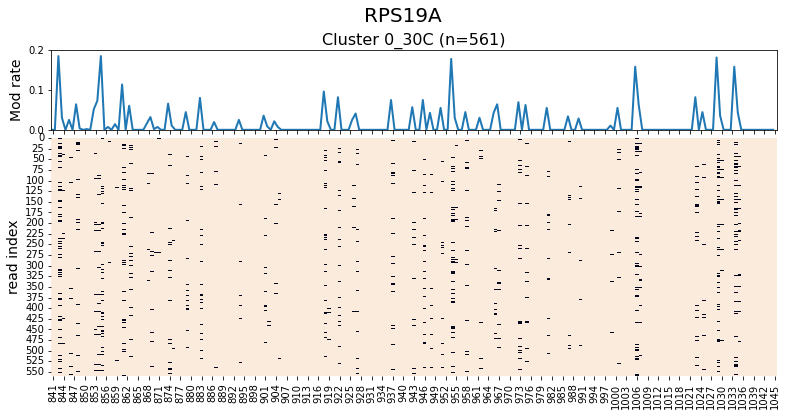

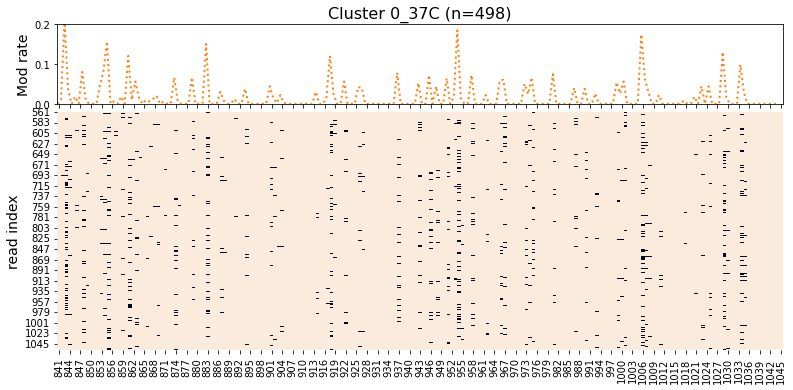

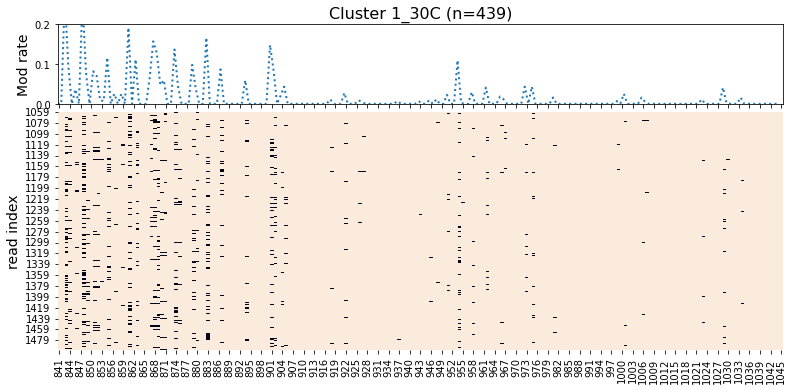

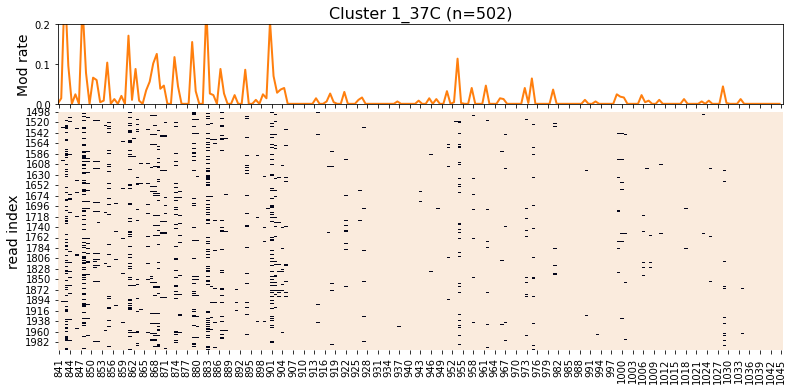

In [22]:
plot_subclusters_lig('orf19.5996.1::RPS19A_841_1046','RPS19A')

In [ ]:
### Supp_Figure 10c --- ---

In [23]:
def plot_subclusters_lig(transcript1,title):

    dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/' 
    pred = pd.read_csv(dir+'/X_pred_'+transcript1+'_1000_0.5.txt', sep='\t') 

    ### prepare the data ---

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    flt = pred[pred['group'] == 'X_pred_WT_inWT']
    X_pred_WT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[pred['group'] == 'X_pred_WT_inMT']
    X_pred_WT_inMT = flt.drop(columns=['iid','group'])
    
    flt = pred[pred['group'] == 'X_pred_MT_inWT']
    X_pred_MT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[pred['group'] == 'X_pred_MT_inMT']
    X_pred_MT_inMT = flt.drop(columns=['iid','group'])

    # plt.suptitle("Main Title", size=16)
    # 1. cluster0_30C

    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)


    ax[0].plot(range(X_pred_WT_inWT.shape[1]), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0_30C (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)

    ## 1. figs
    flt = pred[pred['group'] == 'X_pred_WT_inWT']
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle(title, fontsize=20)
    
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Supp_Fig8c_validate_heatmap_'+transcript1+'_cluster_0_30C.pdf',bbox_inches='tight', dpi=300)


    # 2. cluster0_37C

    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)


    ax[0].plot(range(X_pred_WT_inMT.shape[1]), X_pred_WT_inMT.sum(axis=0)/X_pred_WT_inMT.shape[0], color = colors[1], linewidth=2, linestyle='dotted')
    ax[0].set_title('Cluster 0_37C (n=' + str(X_pred_WT_inMT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)

    ## 1. figs
    flt = pred[pred['group'] == 'X_pred_WT_inMT']
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Supp_Fig8c_validate_heatmap_'+transcript1+'_cluster_0_37C.pdf',bbox_inches='tight', dpi=300)



    # 3. cluster1_30C
    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)


    ax[0].plot(range(X_pred_MT_inWT.shape[1]), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[0], linewidth=2, linestyle='dotted')
    ax[0].set_title('Cluster 1_30C (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)


    flt = pred[pred['group'] == 'X_pred_MT_inWT']
    dplot = flt.drop(columns=['iid','group'])
    
    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Supp_Fig8c_validate_heatmap_'+transcript1+'_cluster_1_30C.pdf',bbox_inches='tight', dpi=300)

    # 4. cluster1_37C
    fig, ax = plt.subplots(2, 1, figsize=(13, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].plot(range(X_pred_MT_inMT.shape[1]), X_pred_MT_inMT.sum(axis=0)/X_pred_MT_inMT.shape[0], color = colors[1], linewidth=2)
    ax[0].set_title('Cluster 1_37C (n=' + str(X_pred_MT_inMT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.2)

    flt = pred[pred['group'] == 'X_pred_MT_inMT']
    dplot = flt.drop(columns=['iid','group'])
    
    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure4/Data/'
    plt.savefig(dir_out+'Supp_Fig8c_validate_heatmap_'+transcript1+'_cluster_1_37C.pdf',bbox_inches='tight', dpi=300)

    fig.show() 

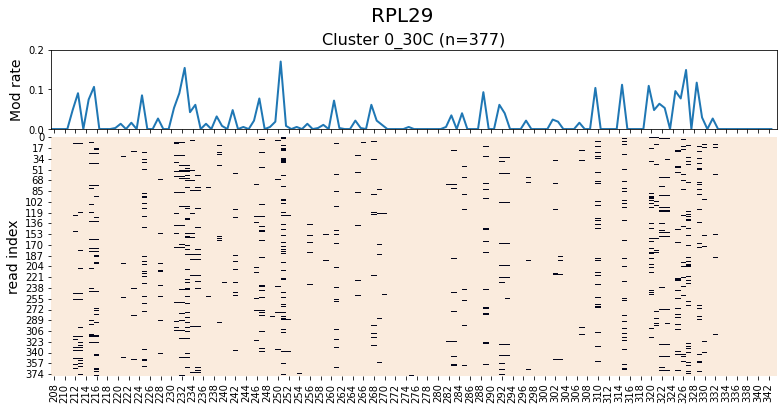

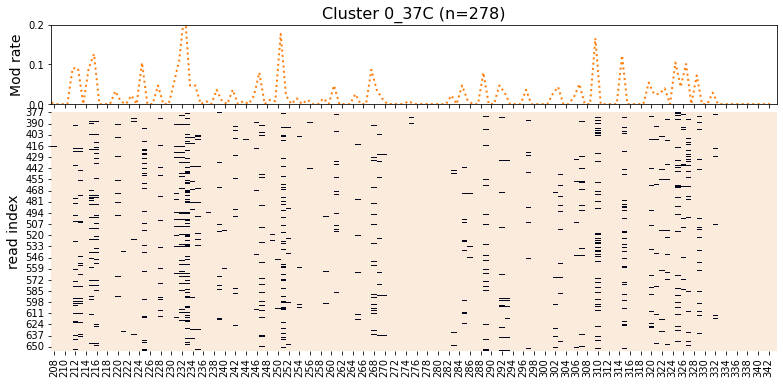

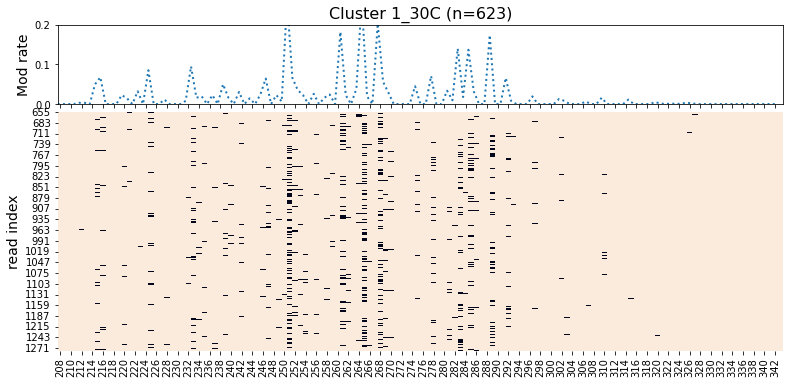

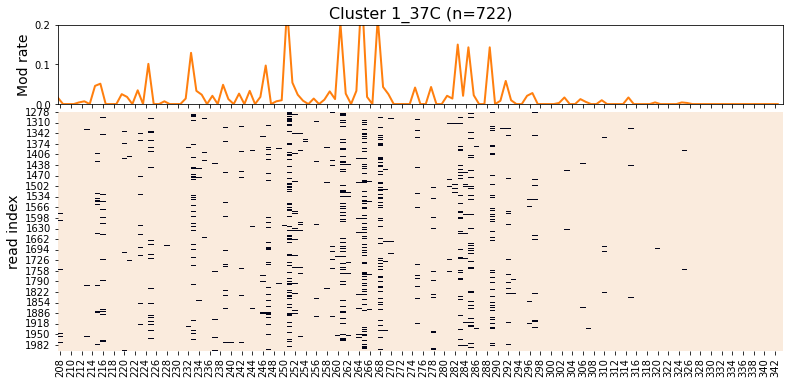

In [24]:
plot_subclusters_lig('orf19.2310.1::RPL29_208_344','RPL29')